In [4]:
import pandas as pd

# Load the JSONL file into a pandas DataFrame
df_tweets = pd.read_json('/content/x_bubble_raw.jsonl', lines=True)

# Display the first 5 rows of the DataFrame
print(df_tweets.head())

              tweet_id                created_at  \
0  2007234056417874176 2026-01-02 23:34:26+00:00   
1  2007228662446543104 2026-01-02 23:13:00+00:00   
2  2007227152631247360 2026-01-02 23:07:00+00:00   
3  2007225196030374400 2026-01-02 22:59:13+00:00   
4  2007222797345665280 2026-01-02 22:49:41+00:00   

                                                text lang  is_reply  \
0  @Vengeancewood When the AI bubble bursts and I...   en      True   
1  $ADBE is a good reminder that revenue growth a...   en     False   
2  AI isn’t a single switch you flip.\n\nIt is a ...   en     False   
3  Anyone who thinks AI is a bubble has never use...   en     False   
4  @ivycomb To be fair, he has to keep smiling ti...   en      True   

       conversation_id  in_reply_to_id  \
0  2007185168784933120    2.007185e+18   
1  2007228662446543104             NaN   
2  2007227152631247360             NaN   
3  2007225196030374400             NaN   
4  2007179060087271680    2.007179e+18   

       

In [5]:
import numpy as np

# Keywords for belief in an AI bubble
believe_keywords = [
    'ai bubble',
    'bubble burst',
    'ai hype',
    'overvalued ai',
    'ai crash',
    'speculative bubble',
    'dot-com bubble',
    'market correction',
    'ponzi scheme'
]

# Keywords for disbelief in an AI bubble
disbelieve_keywords = [
    'not a bubble',
    'no bubble',
    'ai is real',
    'sustainable ai',
    'long-term growth',
    'real value',
    'not hype',
    'fundamental'
]

# Function to classify sentiment
def classify_sentiment(text):
    text = str(text).lower() # Convert to string and lowercase for case-insensitive matching

    believes = any(keyword in text for keyword in believe_keywords)
    disbelieves = any(keyword in text for keyword in disbelieve_keywords)

    if disbelieves and not believes: # Prioritize disbelief if present and belief is not
        return 'Does not believe in AI bubble'
    elif believes and not disbelieves:
        return 'Believes in AI bubble'
    elif disbelieves and believes: # If both are present, prioritize disbelief as per instructions
        return 'Does not believe in AI bubble'
    else:
        return 'Neutral/Unclear'

# Apply the function to the 'text' column to create the 'sentiment' column
df_tweets['sentiment'] = df_tweets['text'].apply(classify_sentiment)

# Display the first few rows with the new sentiment column and value counts
print(df_tweets[['text', 'sentiment']].head())
print('\nSentiment Distribution:')
print(df_tweets['sentiment'].value_counts())

                                                text              sentiment
0  @Vengeancewood When the AI bubble bursts and I...  Believes in AI bubble
1  $ADBE is a good reminder that revenue growth a...  Believes in AI bubble
2  AI isn’t a single switch you flip.\n\nIt is a ...        Neutral/Unclear
3  Anyone who thinks AI is a bubble has never use...        Neutral/Unclear
4  @ivycomb To be fair, he has to keep smiling ti...  Believes in AI bubble

Sentiment Distribution:
sentiment
Neutral/Unclear                  720
Believes in AI bubble            340
Does not believe in AI bubble     97
Name: count, dtype: int64


In [6]:
sentiment_counts = df_tweets['sentiment'].value_counts()
sentiment_proportions = df_tweets['sentiment'].value_counts(normalize=True) * 100

print('\nSentiment Proportions:')
print(sentiment_proportions)


Sentiment Proportions:
sentiment
Neutral/Unclear                  62.229905
Believes in AI bubble            29.386344
Does not believe in AI bubble     8.383751
Name: proportion, dtype: float64


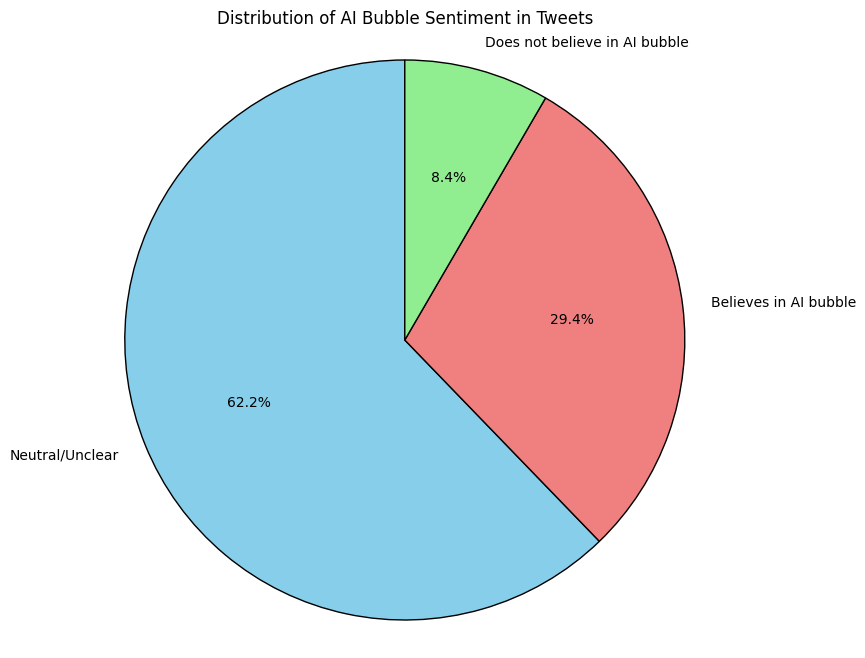

In [7]:
import matplotlib.pyplot as plt

# Recalculate sentiment_proportions to ensure it's available
sentiment_proportions = df_tweets['sentiment'].value_counts(normalize=True) * 100

# Create a pie chart
plt.figure(figsize=(10, 8))
colors = ['skyblue', 'lightcoral', 'lightgreen']
plt.pie(sentiment_proportions, labels=sentiment_proportions.index, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})

# Add title
plt.title('Distribution of AI Bubble Sentiment in Tweets')

# Ensure the circle is drawn as a circle (otherwise it will be an oval)
plt.axis('equal')

# Display the plot
plt.show()

In [8]:
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

JSONL_PATH = Path("x_bubble_raw.jsonl")  # change if needed
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

# Load JSONL

def load_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    bad = 0
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError:
                bad += 1
    df = pd.DataFrame(rows)
    if bad:
        print(f"Warning: skipped {bad} malformed lines.")
    return df

df = load_jsonl(JSONL_PATH)
df = df[df["lang"].fillna("") == "en"].copy()
df["text"] = df["text"].fillna("").astype(str)

#
# Text preprocessing (tweet-aware)
#    - mentions -> <USER>, urls -> <URL>, keep $TICKER and hashtags as tokens
URL_RE = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
WHITESPACE_RE = re.compile(r"\s+")
NONWORD_RE = re.compile(r"[^a-z0-9#\$\<\>\s]")

nltk.download("stopwords", quiet=True)
STOPWORDS = set(stopwords.words("english"))
STEMMER = PorterStemmer()

def normalize_tweet(text: str) -> str:
    t = text.lower()
    t = URL_RE.sub(" <URL> ", t)
    t = MENTION_RE.sub(" <USER> ", t)
    # keep #hashtags and $cashtags; remove other punctuation
    t = NONWORD_RE.sub(" ", t)
    t = WHITESPACE_RE.sub(" ", t).strip()
    return t

def tokenize_and_stem(text: str) -> list[str]:
    # simple whitespace tokenization (enough for TF-IDF)
    tokens = text.split()
    # remove stopwords except special markers
    kept = []
    for tok in tokens:
        if tok in {"<url>", "<user>"}:
            kept.append(tok)
            continue
        # drop pure stopwords
        if tok in STOPWORDS:
            continue
        # porter stemmer as per my notes
        kept.append(STEMMER.stem(tok))
    return kept

def preprocess_for_vectorizer(text: str) -> str:
    t = normalize_tweet(text)
    toks = tokenize_and_stem(t)
    return " ".join(toks)

df["text_clean"] = df["text"].map(preprocess_for_vectorizer)

# Weak supervision to bootstrap labels (so you can train a classifier)
#    Labels:
#      1 = "bubble" stance (believes there is an AI bubble)
#      0 = "not_bubble" stance (rejects bubble)
#    Anything ambiguous -> -1 (excluded from training)

BUBBLE_CUES = [
    "ai bubbl", "bubble", "overvalu", "mania", "froth", "hype", "irration",
    "bubble burst", "burst", "pop", "crash", "correction", "implod"
]
NOT_BUBBLE_CUES = [
    "not a bubble", "no bubble", "isn t a bubble", "isnt a bubble", "never a bubble",
    "real value", "not hype", "fundament", "productivit", "here to stay"
]

def weak_label(text_clean: str) -> int:
    # strong explicit negations first
    for cue in NOT_BUBBLE_CUES:
        if cue in text_clean:
            return 0
    for cue in BUBBLE_CUES:
        if cue in text_clean:
            return 1
    return -1

df["y_weak"] = df["text_clean"].map(weak_label)

train_df = df[df["y_weak"].isin([0, 1])].copy()
print(f"Weak-labeled training examples: {len(train_df):,} / {len(df):,}")


# Model: TF-IDF with n-grams + Logistic Regression
#    - TF-IDF weighting
#    - n-grams

X_train, X_test, y_train, y_test = train_test_split(
    train_df["text_clean"],
    train_df["y_weak"].astype(int),
    test_size=0.2,
    random_state=42,
    stratify=train_df["y_weak"].astype(int),
)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),          # unigrams + bigrams
        min_df=2,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=None
    ))
])

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("\n--- Weak-label evaluation (expect noise) ---")
print(classification_report(y_test, pred, target_names=["not_bubble",
                                                        "bubble"]))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


# Train on all weak-labeled data, then predict stance for all tweets

clf.fit(train_df["text_clean"], train_df["y_weak"].astype(int))

proba = clf.predict_proba(df["text_clean"])
# proba columns follow sorted classes; get class index for "bubble" (=1)
bubble_idx = list(clf.named_steps["lr"].classes_).index(1)
df["p_bubble"] = proba[:, bubble_idx]
df["stance_pred"] = np.where(df["p_bubble"] >= 0.5, "bubble", "not_bubble")

# Simple headline stats
pct_bubble = (df["stance_pred"] == "bubble").mean() * 100
print(f"\nEstimated % bubble stance (model-based): {pct_bubble:.1f}%")

# Save outputs
df_out = df[["tweet_id", "created_at", "text", "text_clean", "stance_pred",
             "p_bubble"]].copy()
df_out.to_csv(OUT_DIR / "x_bubble_with_stance.csv", index=False)
print(f"Saved: {OUT_DIR / 'x_bubble_with_stance.csv'}")


#  Inspect what the model is learning (top features)

tfidf = clf.named_steps["tfidf"]
lr = clf.named_steps["lr"]
feature_names = np.array(tfidf.get_feature_names_out())

coef = lr.coef_[0]
top_pos = feature_names[np.argsort(coef)[-30:]][::-1]   # bubble-indicative
top_neg = feature_names[np.argsort(coef)[:30]]          # not-bubble-indicative

print("\nTop terms pushing toward 'bubble':")
print(top_pos)

print("\nTop terms pushing toward 'not_bubble':")
print(top_neg)


#  Export a hand-label set to replace weak labels

sample_for_labeling = df.sample(n=min(500, len(df)), random_state=7)[
    ["tweet_id", "created_at", "text", "stance_pred", "p_bubble"]
].copy()
sample_for_labeling["human_label"] = ""  # fill with: bubble / not_bubble / unclear
sample_for_labeling.to_csv(OUT_DIR / "label_me.csv", index=False)
print(f"\nSaved a labeling sheet: {OUT_DIR / 'label_me.csv'}")


Weak-labeled training examples: 1,003 / 1,157

--- Weak-label evaluation (expect noise) ---
              precision    recall  f1-score   support

  not_bubble       1.00      0.14      0.25         7
      bubble       0.97      1.00      0.98       194

    accuracy                           0.97       201
   macro avg       0.98      0.57      0.62       201
weighted avg       0.97      0.97      0.96       201

Confusion matrix:
 [[  1   6]
 [  0 194]]

Estimated % bubble stance (model-based): 97.1%
Saved: outputs/x_bubble_with_stance.csv

Top terms pushing toward 'bubble':
['ai bubbl' 'bubbl' 'bubbl burst' 'burst' 'pop' 'crypto' 'without' 'year'
 'new' 'work' 'signal' 'predict' 'take' 'know' 'even' 'time' 'bubbl pop'
 'go' 'game' 'amp' 'read' 'ship' 'final' 'win' 'last' 'evolv' 'get'
 'world' 'post' 'believ']

Top terms pushing toward 'not_bubble':
['fundament' 'focu' 'data' 'focu fundament' 'mechan' 'return' 'learn use'
 'revenu' 'capex' 'monthli' 'fundament quietli' 'make ai' 'e

In [9]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

# Paths
JSONL_PATH = Path("/content/x_bubble_raw.jsonl")
OUT_DIR = Path("/mnt/data/outputs_q2")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load JSONL
def load_jsonl(path: Path) -> pd.DataFrame:
    rows, bad = [], 0
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError:
                bad += 1
    df = pd.DataFrame(rows)
    if bad:
        print(f"Warning: skipped {bad} malformed lines.")
    return df

df = load_jsonl(JSONL_PATH)

# Keep only what I need
needed = ["tweet_id", "created_at", "text", "lang"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required fields in JSONL: {missing}")

df = df[df["lang"].fillna("") == "en"].copy()
df["text"] = df["text"].fillna("").astype(str)

In [ ]:
# Parse time + add date buckets

df["created_at_dt"] = pd.to_datetime(df["created_at"], utc=True, errors="coerce")
df = df.dropna(subset=["created_at_dt"]).copy()
df["day"] = df["created_at_dt"].dt.floor("D")

# Tweet-aware preprocessing (normalize -> tokenise -> stem)

nltk.download("stopwords", quiet=True)
STOPWORDS = set(stopwords.words("english"))
STEMMER = PorterStemmer()

URL_RE = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
WHITESPACE_RE = re.compile(r"\s+")

# Keep: letters, digits, whitespace, hashtags, cashtags, and <USER>/<URL>
NONWORD_RE = re.compile(r"[^a-z0-9#\$\s\<\>]")

def normalize_tweet(text: str) -> str:
    t = text.lower()
    t = URL_RE.sub(" <URL> ", t)
    t = MENTION_RE.sub(" <USER> ", t)
    t = NONWORD_RE.sub(" ", t)
    t = WHITESPACE_RE.sub(" ", t).strip()
    return t

def tokenize_and_stem(text: str) -> list[str]:
    tokens = text.split()
    out = []
    for tok in tokens:
        if tok in {"<url>", "<user>"}:
            out.append(tok)
            continue
        if tok in STOPWORDS:
            continue
        out.append(STEMMER.stem(tok))
    return out

def preprocess(text: str) -> str:
    t = normalize_tweet(text)
    toks = tokenize_and_stem(t)
    return " ".join(toks)

df["text_clean"] = df["text"].map(preprocess)

In [ ]:
BUBBLE_CUES = [
    "ai bubbl", "bubble", "overvalu", "mania", "froth", "hype", "irration",
    "burst", "pop", "crash", "correction", "implod"
]
NOT_BUBBLE_CUES = [
    "not a bubble", "no bubble", "isn t a bubble", "isnt a bubble",
    "never a bubble", "real value", "fundament", "here to stay"
]

In [ ]:
# Build stance model (bubble vs not_bubble) so Q2 can filter
#    Weak labels from rules -> TF-IDF -> logistic regression

def weak_label(text_clean: str) -> int:
    # explicit "not bubble" first
    for cue in NOT_BUBBLE_CUES:
        if cue in text_clean:
            return 0
    for cue in BUBBLE_CUES:
        if cue in text_clean:
            return 1
    return -1

df["y_weak"] = df["text_clean"].map(weak_label)
train_df = df[df["y_weak"].isin([0, 1])].copy()

print(f"Weak-labeled training examples: {len(train_df):,} / {len(df):,}")
if len(train_df) < 50:
    raise RuntimeError("Too few weak-labeled examples. Expand cue lists or label some data manually.")

X_train, X_test, y_train, y_test = train_test_split(
    train_df["text_clean"],
    train_df["y_weak"].astype(int),
    test_size=0.2,
    random_state=42,
    stratify=train_df["y_weak"].astype(int),
)

stance_clf = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9, sublinear_tf=True)),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

stance_clf.fit(X_train, y_train)
pred = stance_clf.predict(X_test)

print("\n--- Stance weak-label evaluation (expect noise) ---")
print(classification_report(y_test, pred, target_names=["not_bubble", "bubble"]))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

In [ ]:
# Train on full weak-labeled set and predict all
stance_clf.fit(train_df["text_clean"], train_df["y_weak"].astype(int))
proba = stance_clf.predict_proba(df["text_clean"])
bubble_idx = list(stance_clf.named_steps["lr"].classes_).index(1)

df["p_bubble"] = proba[:, bubble_idx]
df["stance_pred"] = np.where(df["p_bubble"] >= 0.5, "bubble", "not_bubble")

print(f"\nEstimated % bubble stance (model-based): {(df['stance_pred']=='bubble').mean()*100:.1f}%")

# Filter to bubble-believer tweets

bubble_df = df[df["stance_pred"] == "bubble"].copy()
print(f"Bubble-believer tweets for Q2: {len(bubble_df):,}")

In [ ]:
#  Burst Imminence Index + sentiment over time

IMMINENCE_TERMS = [
    r"\bburst\b", r"\bbursts\b", r"\bbursting\b",
    r"\bpop\b", r"\bpops\b", r"\bpopping\b",
    r"\bcrash\b", r"\bcrashes\b", r"\bcrashing\b",
    r"\bcorrection\b", r"\bmeltdown\b", r"\bimplod(e|ing)\b",
    r"\bcapitul(ate|ation)\b", r"\bdownturn\b", r"\bcollapse\b"
]
SOON_TERMS = [
    r"\bsoon\b", r"\bimminent\b", r"\bany day\b", r"\babout to\b", r"\bclose to\b",
    r"\bthis year\b", r"\bwithin\b", r"\bnext (few|couple)\b", r"\bin (days|weeks|months)\b",
    r"\bnear[- ]term\b"
]
HEDGE_TERMS = [
    r"\bmight\b", r"\bmaybe\b", r"\bcould\b", r"\bpossible\b", r"\bpossibly\b",
    r"\buncertain\b", r"\bnot sure\b", r"\bi (think|guess)\b"
]

In [ ]:
IMMINENCE_RE = re.compile("|".join(IMMINENCE_TERMS), flags=re.IGNORECASE)
SOON_RE = re.compile("|".join(SOON_TERMS), flags=re.IGNORECASE)
HEDGE_RE = re.compile("|".join(HEDGE_TERMS), flags=re.IGNORECASE)

def burst_imminence_score(text: str) -> float:
    if not isinstance(text, str):
        return 0.0
    immin = 1.0 if IMMINENCE_RE.search(text) else 0.0
    soon = 1.0 if SOON_RE.search(text) else 0.0
    hedge = 1.0 if HEDGE_RE.search(text) else 0.0
    score = immin + 0.75 * soon - 0.25 * hedge
    return float(max(score, 0.0))

bubble_df["burst_imminence"] = bubble_df["text"].apply(burst_imminence_score)

analyzer = SentimentIntensityAnalyzer()
bubble_df["sentiment_compound"] = bubble_df["text"].astype(str).apply(
    lambda t: analyzer.polarity_scores(t)["compound"]
)

daily = (
    bubble_df.groupby("day")
    .agg(
        n=("tweet_id", "count"),
        mean_imminence=("burst_imminence", "mean"),
        share_imminent=("burst_imminence", lambda x: float((x >= 1.0).mean())),
        mean_sentiment=("sentiment_compound", "mean")
    )
    .reset_index()
    .sort_values("day")
)

daily["mean_imminence_7d"] = daily["mean_imminence"].rolling(7, min_periods=1).mean()
daily["share_imminent_7d"] = daily["share_imminent"].rolling(7, min_periods=1).mean()
daily["mean_sentiment_7d"] = daily["mean_sentiment"].rolling(7, min_periods=1).mean()

In [ ]:
# Plots - Each plot individually
plt.figure(figsize=(10, 6))
plt.plot(daily["day"], daily["mean_imminence_7d"])
plt.title("Q2: Burst Imminence Index (7-day rolling) among bubble-believer tweets")
plt.xlabel("Date")
plt.ylabel("Mean burst imminence score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(daily["day"], daily["share_imminent_7d"])
plt.title("Q2: Share mentioning bursting/correction (7-day rolling) among bubble-believer tweets")
plt.xlabel("Date")
plt.ylabel("Share")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(daily["day"], daily["mean_sentiment_7d"])
plt.title("Q2: Mean sentiment (VADER compound, 7-day rolling) among bubble-believer tweets")
plt.xlabel("Date")
plt.ylabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Topic modelling (LDA) + association with imminence

bubble_df["is_imminent"] = (bubble_df["burst_imminence"] >= 1.0).astype(int)

# LDA needs counts
text_for_topics = bubble_df["text_clean"].fillna(bubble_df["text"].astype(str))

vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    stop_words="english"
)
X = vectorizer.fit_transform(text_for_topics)

n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method="batch")
doc_topic = lda.fit_transform(X)

topic_names = [f"topic_{k}" for k in range(n_topics)]
bubble_df[topic_names] = doc_topic

feature_names = np.array(vectorizer.get_feature_names_out())

def print_top_words(model, feature_names, n_top_words=12):
    for topic_idx, topic in enumerate(model.components_):
        top_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_terms = feature_names[top_ind]
        print(f"\nTopic {topic_idx}: " + ", ".join(top_terms))

print_top_words(lda, feature_names, n_top_words=12)

/tmp/ipython-input-1849995405.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at_dt"] = pd.to_datetime(df["created_at"], utc=True, errors="coerce")


Weak-labeled training examples: 1,003 / 1,157

--- Stance weak-label evaluation (expect noise) ---
              precision    recall  f1-score   support

  not_bubble       1.00      0.14      0.25         7
      bubble       0.97      1.00      0.98       194

    accuracy                           0.97       201
   macro avg       0.98      0.57      0.62       201
weighted avg       0.97      0.97      0.96       201

Confusion matrix:
 [[  1   6]
 [  0 194]]

Estimated % bubble stance (model-based): 97.1%
Bubble-believer tweets for Q2: 1,124


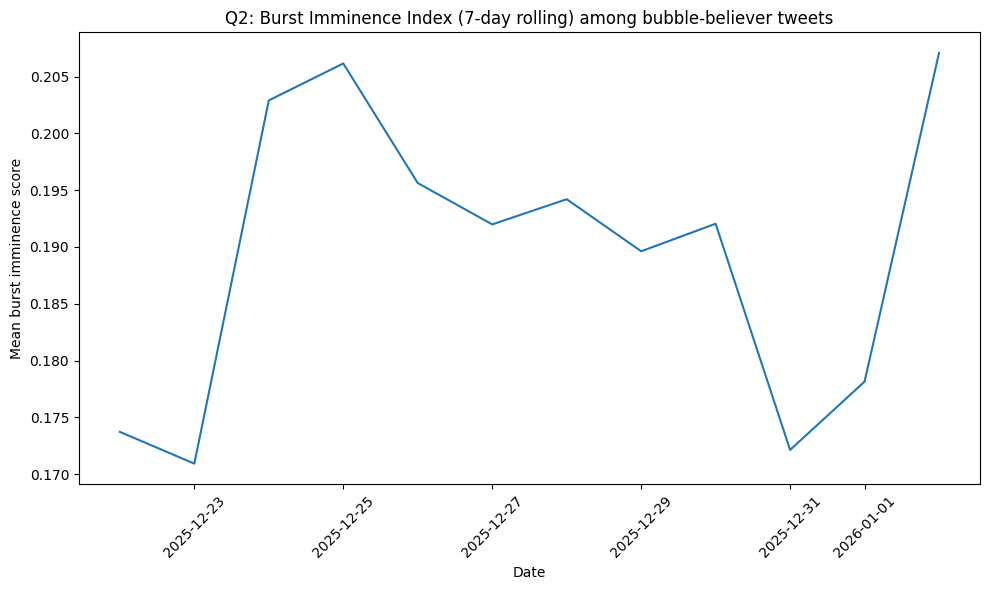

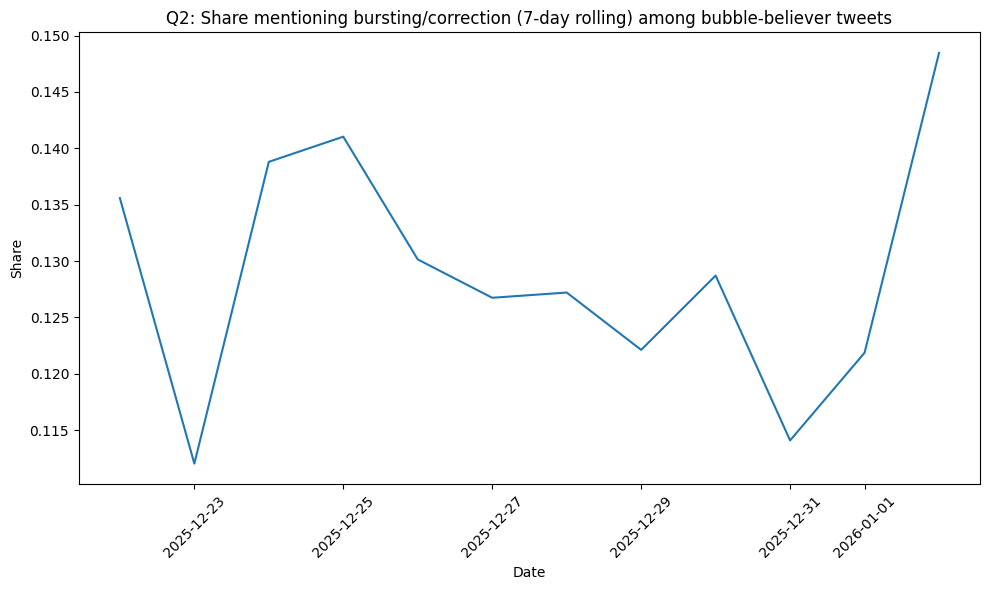

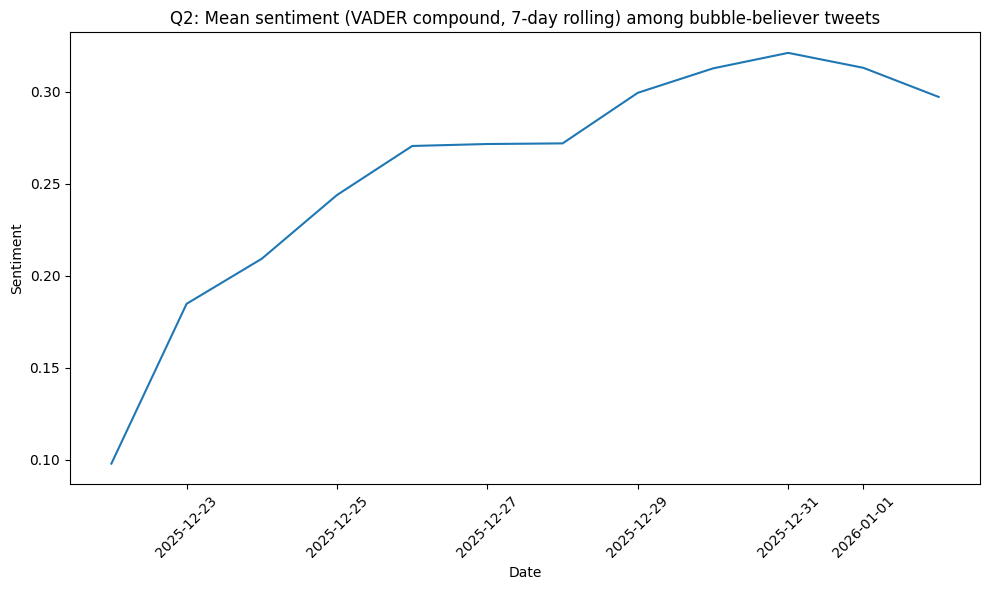


Topic 0: bubbl, 2026, year, hype, ai bubbl, peopl, tech, data, market, 2025, crypto, ai hype

Topic 1: real, hype, agent, build, actual, like, chain, infrastructur, feel, project, user, layer

Topic 2: bubbl, ai bubbl, pop, burst, bubbl burst, like, peopl, bubbl pop, year, say, stock, think

Topic 3: verifi, proof, infer, trust, dagama, hype, real, world, lab, like, infer lab, everi

Topic 4: market, bubbl, compani, hype, like, investor, tech, money, real, data, time, year

Topic 5: hype, real, token, 2025, trade, 2026, year, narr, new, launch, strong, come


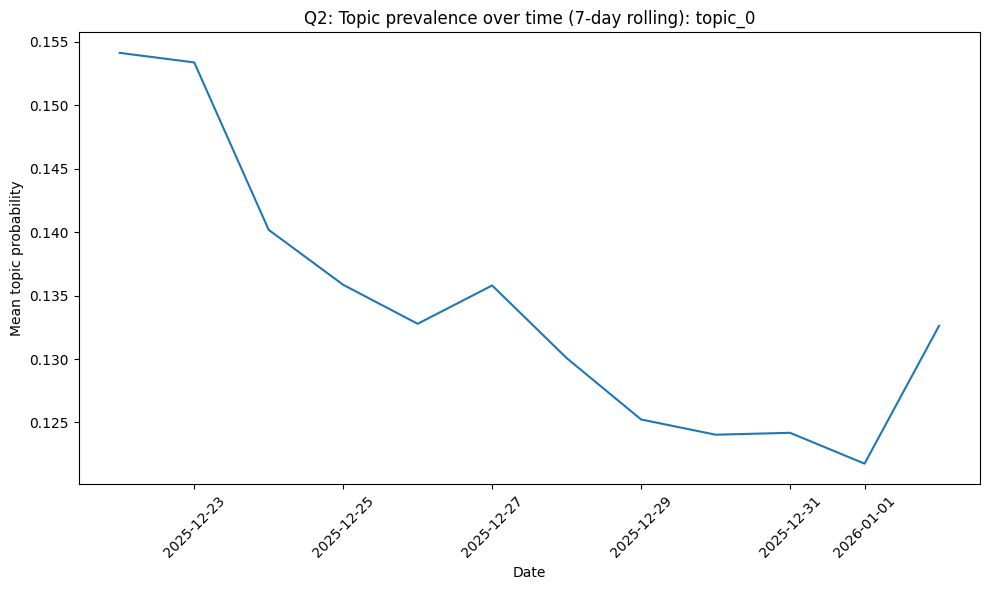

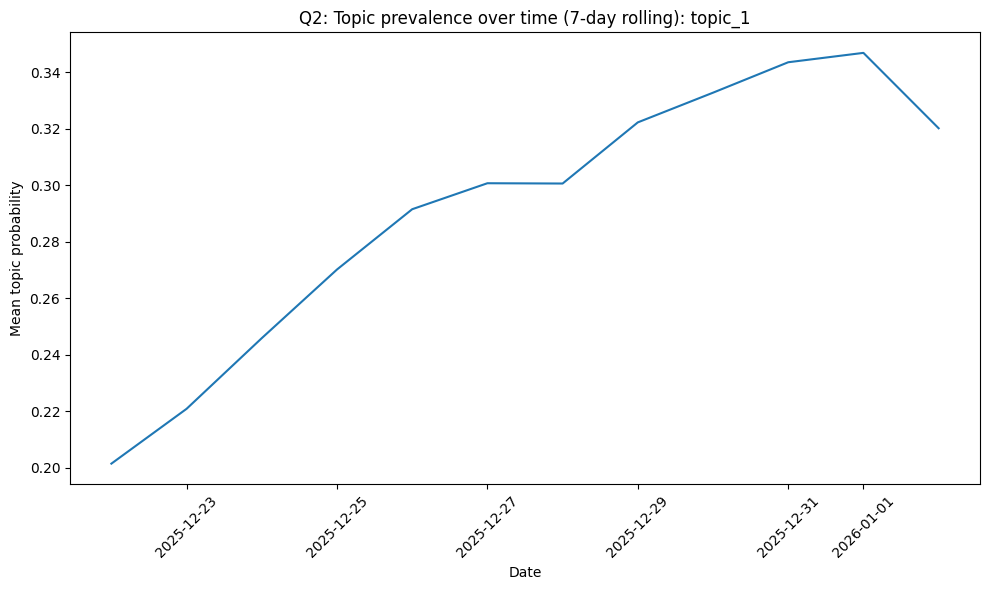

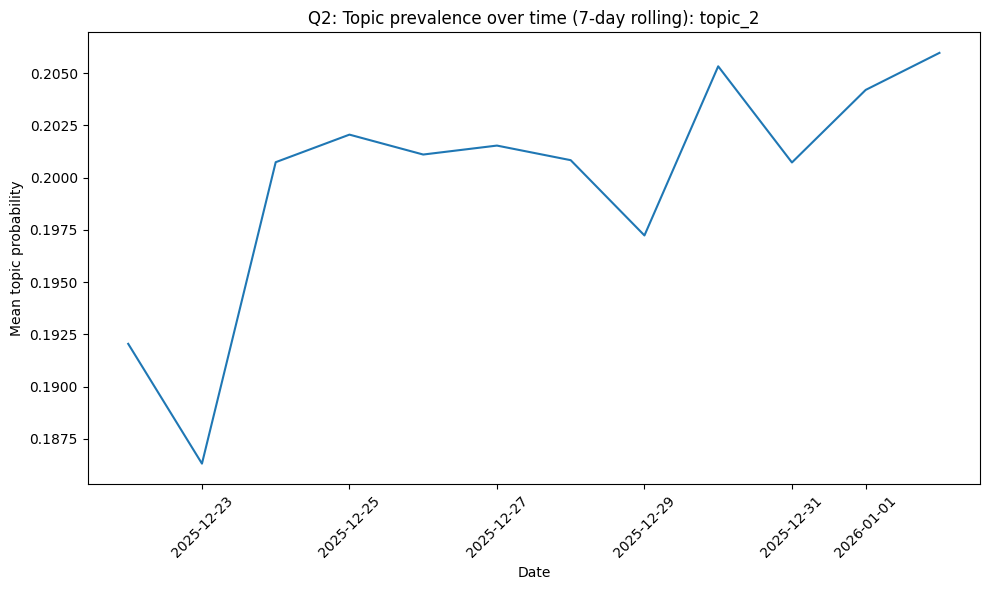

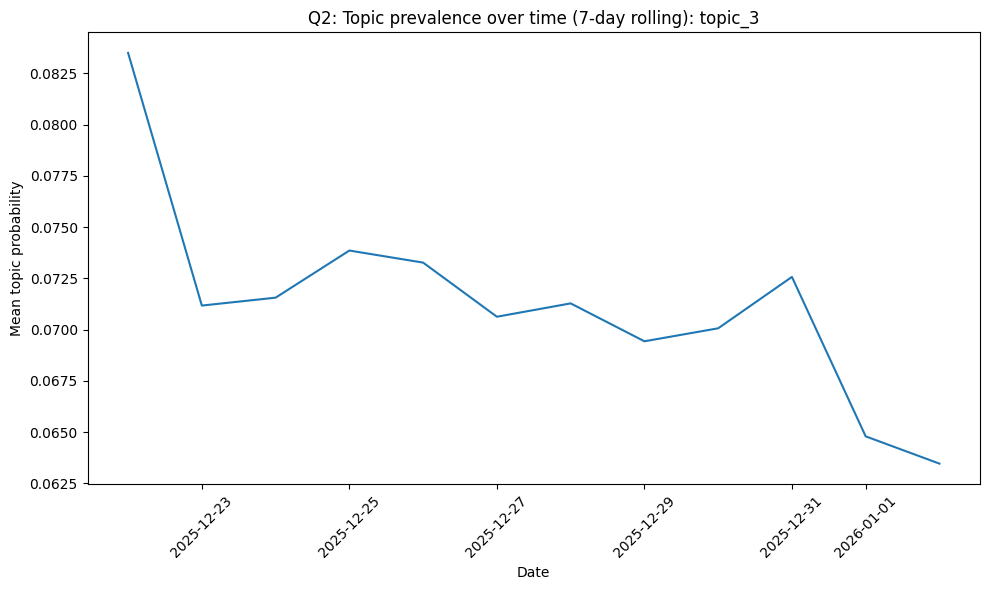

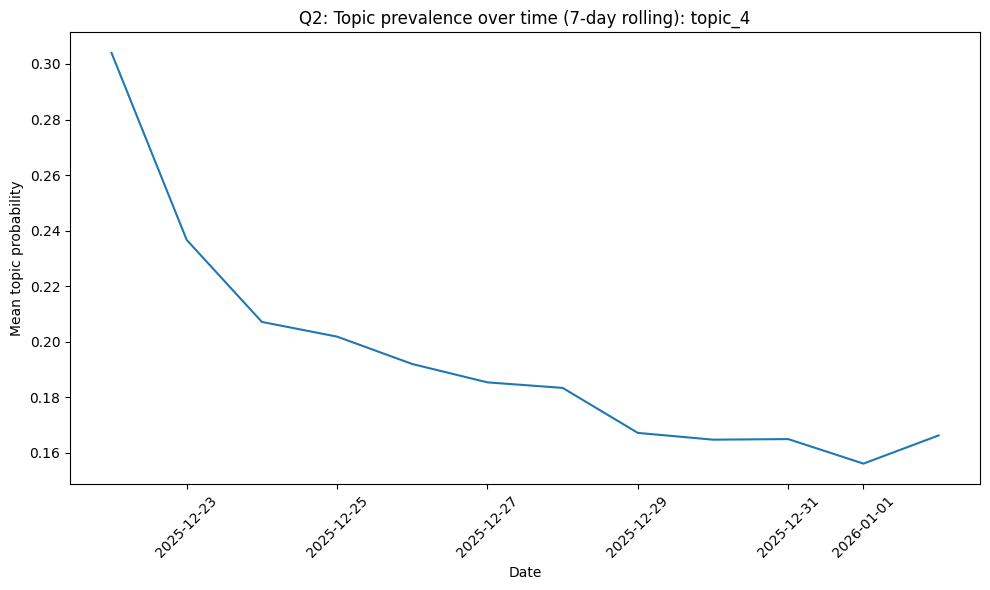

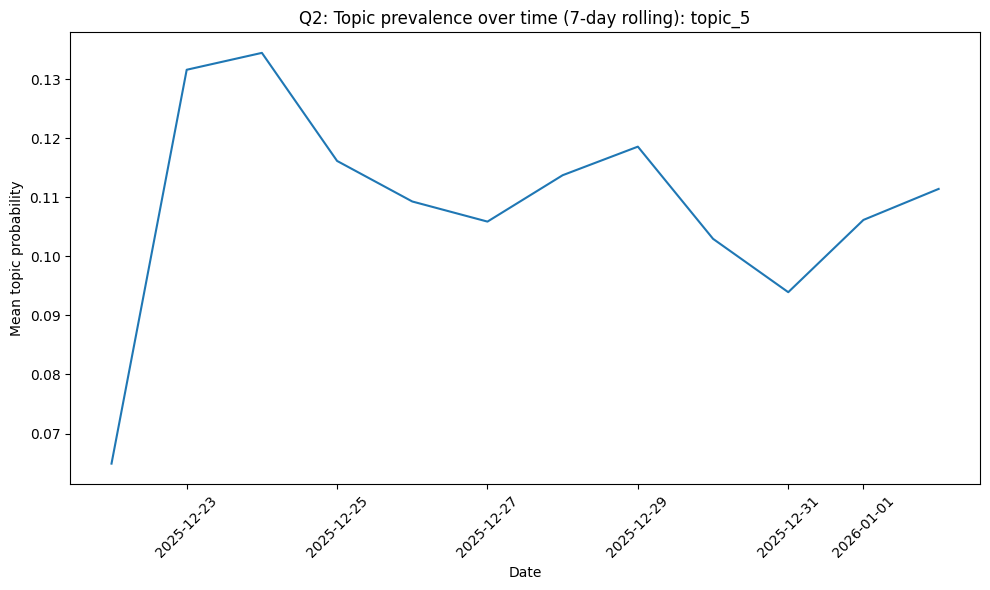


Topic association with imminent bursting language (mean difference):
topic_2    0.321039
topic_0    0.070529
topic_4   -0.007339
topic_3   -0.035196
topic_5   -0.072214
topic_1   -0.276819
dtype: float64

Saved files:
 - /mnt/data/outputs_q2/all_tweets_with_stance.csv
 - /mnt/data/outputs_q2/q2_bubble_tweets_with_imminence_topics.csv
 - /mnt/data/outputs_q2/q2_daily_imminence_sentiment.csv
 - /mnt/data/outputs_q2/q2_topic_trends_daily.csv


In [14]:
# Topic trends over time - Each plot individually
topic_daily = (
    bubble_df.groupby("day")[topic_names]
    .mean()
    .reset_index()
    .sort_values("day")
)

for t in topic_names:
    plt.figure(figsize=(10, 6))
    plt.plot(topic_daily["day"], topic_daily[t].rolling(7, min_periods=1).mean())
    plt.title(f"Q2: Topic prevalence over time (7-day rolling): {t}")
    plt.xlabel("Date")
    plt.ylabel("Mean topic probability")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Which topics are most associated with imminence?
topic_means = bubble_df.groupby("is_imminent")[topic_names].mean()
diff = (topic_means.loc[1] - topic_means.loc[0]).sort_values(ascending=False)

print("\nTopic association with imminent bursting language (mean difference):")
print(diff)

# Save outputs for your report

df.to_csv(OUT_DIR / "all_tweets_with_stance.csv", index=False)
bubble_df.to_csv(OUT_DIR / "q2_bubble_tweets_with_imminence_topics.csv", index=False)
daily.to_csv(OUT_DIR / "q2_daily_imminence_sentiment.csv", index=False)
topic_daily.to_csv(OUT_DIR / "q2_topic_trends_daily.csv", index=False)

print("\nSaved files:")
print(" -", OUT_DIR / "all_tweets_with_stance.csv")
print(" -", OUT_DIR / "q2_bubble_tweets_with_imminence_topics.csv")
print(" -", OUT_DIR / "q2_daily_imminence_sentiment.csv")
print(" -", OUT_DIR / "q2_topic_trends_daily.csv")
